# COVID-19 Corpus Analysis

In [1]:
import string
import re
import spacy 
import nltk
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
from nltk.stem import WordNetLemmatizer
from nltk import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('wordnet')

#To Temporarily Remove Deprecation Warning
import warnings
#warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/CAMPUS/jrab2017/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/CAMPUS/jrab2017/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
data = pd.read_csv('/raid/tft-data/data-covid/covid_combined.csv')
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17894 entries, 0 to 17893
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   17894 non-null  object
 1   label   17894 non-null  object
dtypes: object(2)
memory usage: 419.4+ KB


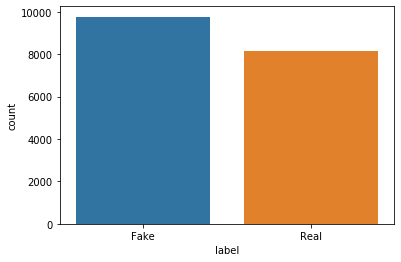

In [3]:
sns.countplot(data['label'])

count    17894.000000
mean        13.437577
std          8.544929
min          1.000000
25%          8.000000
50%         11.000000
75%         16.000000
max         84.000000
Name: length, dtype: float64

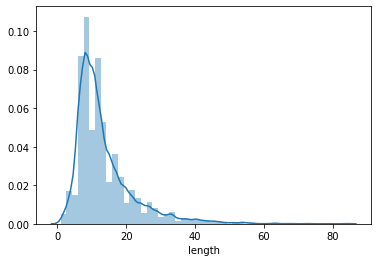

In [4]:
data['length'] = data['title'].apply(lambda x: len(x.split(' ')))
sns.distplot(data['length'])
data['length'].describe()

In [5]:
# main tokenizing function
def tokenize_line(line, chars_to_exclude, stopwords, tokenizer, stem_tokens=False, stemmer=None, lemm_tokens=False, lemmatizer=None):
    # removing unwanted characters and numbers from the string
    pattern = '[' + '|'.join(list(chars_to_exclude)) + '|\d]*'
    line = re.sub(pattern, "", line).lower()

    # generating tokens
    tokens = [token for token in tokenizer.tokenize(line) if token not in stopwords]
    
    # stemming the tokens if the user wants to
    if stem_tokens:
        tokens = [stemmer.stem(token) for token in tokens]

    # lemmatizing the tokens if the user wants to
    if lemm_tokens:
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return tokens

In [6]:
# function to help with tokenizing columns
def tokenize_lines(lines, chars_to_exclude, stopwords, tokenizer=None, stem_tokens=False, stemmer=None, lemm_tokens=False, lemmatizer=None):

    all_tokens = [tokenize_line(line, chars_to_exclude, stopwords, tokenizer, stem_tokens, stemmer, lemm_tokens, lemmatizer) for line in lines]

    return np.array(all_tokens)

In [7]:
# the default parameters for now
def get_default_tokenization_params():
    chars_to_exclude = string.punctuation
    english_stopwords = set(stopwords.words('english'))
    tokenizer = RegexpTokenizer("\w+")

    #Modify these according to the user's choices
    stem_tokens = False
    stemmer = PorterStemmer()

    lemm_tokens = True
    lemmatizer = WordNetLemmatizer()

    return (chars_to_exclude, english_stopwords, tokenizer, stem_tokens, stemmer, lemm_tokens, lemmatizer)

In [8]:
X = tokenize_lines(data['title'], *get_default_tokenization_params())
Y = data['label']
data_processed = pd.DataFrame(({'title': data['title'], 'title': X, 'label': Y}))

/home/CAMPUS/jrab2017/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


## Topic Modeling using LDA 

In [9]:
# Import all necessary libraries
# Gensim library for additional topic modeling and statistical anlysis
# Corpora module implements dictionary-mapping between words and corresponding integer IDs
import gensim
import pickle
import pyLDAvis.sklearn
import pyLDAvis.gensim_models
from gensim import corpora
from gensim.models import CoherenceModel
from sklearn.decomposition import LatentDirichletAllocation

html_dir = '~/Project/cs152sp21-project/Corpus Analysis/htmls/'
num_topics = 10 
num_features = 100

### Real News

In [10]:
real_news = data_processed[data_processed['label'] == 'Real']
real_text= real_news['title']
real_gensim_dictionary = corpora.Dictionary(real_text)

#creating bag of words (bow) w/ real_text
real_gensim_corpus = [real_gensim_dictionary.doc2bow(token, allow_update=True) for token in real_text]

#saving dictionary and bow (via pickle )to use for predictions below
real_corpus_file = 'real_gensim_corpus.pkl'
pickle.dump(real_gensim_corpus, open(real_corpus_file, 'wb'))
real_gensim_dictionary.save('real_gensim_dictionary.gensim')

In [11]:
real_lda_model = gensim.models.ldamodel.LdaModel(real_gensim_corpus, num_topics=num_topics, id2word=real_gensim_dictionary, passes=10)
real_lda_model.save('real_gensim_model.gensim')

In [12]:
#Print 5 words per topic
topics = real_lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.050*"covid" + 0.041*"mask" + 0.030*"tuberculosis" + 0.028*"pandemic" + 0.023*"wear"')
(1, '0.087*"food" + 0.037*"covid" + 0.034*"safe" + 0.032*"virus" + 0.029*"home"')
(2, '0.064*"covid" + 0.033*"measure" + 0.026*"used" + 0.024*"coronavirus" + 0.020*"use"')
(3, '0.084*"covid" + 0.040*"health" + 0.038*"risk" + 0.018*"guidance" + 0.017*"tobacco"')
(4, '0.067*"covid" + 0.026*"health" + 0.025*"u" + 0.025*"case" + 0.019*"likely"')
(5, '0.076*"covid" + 0.051*"workplace" + 0.032*"malaria" + 0.023*"protect" + 0.022*"country"')
(6, '0.086*"covid" + 0.030*"dexamethasone" + 0.025*"vaccine" + 0.022*"sars" + 0.021*"test"')
(7, '0.087*"covid" + 0.029*"risk" + 0.025*"people" + 0.021*"state" + 0.019*"know"')
(8, '0.105*"covid" + 0.019*"breastfeed" + 0.018*"get" + 0.018*"people" + 0.016*"symptom"')
(9, '0.049*"covid" + 0.033*"care" + 0.029*"confirmed" + 0.028*"suspected" + 0.023*"healthcare"')


In [13]:
coherence_score_lda = CoherenceModel(model=real_lda_model, texts=real_text, dictionary=real_gensim_dictionary, coherence='c_v')
coherence_score = coherence_score_lda.get_coherence()

print('\nPerplexity:', real_lda_model.log_perplexity(real_gensim_corpus))
print('\nCoherence Score:', coherence_score)


Perplexity: -7.389577007199733

Coherence Score: 0.47675069112416313


In [14]:
real_gensim_dictionary = gensim.corpora.Dictionary.load('real_gensim_dictionary.gensim')
real_gensim_corpus = pickle.load(open(real_corpus_file, 'rb'))
real_lda_model = gensim.models.ldamodel.LdaModel.load('real_gensim_model.gensim')


real_lda_visualization = pyLDAvis.gensim_models.prepare(real_lda_model, real_gensim_corpus, real_gensim_dictionary, sort_topics=False)
pyLDAvis.enable_notebook()
pyLDAvis.save_html(real_lda_visualization, 'covid_real_news_lda.html')
print('Real News LDA Model saved as HTML File!')

Real News LDA Model saved as HTML File!


### Fake News

In [15]:
# Prepare relevant data 
fake_news = data_processed[data_processed['label'] == 'Fake']
fake_text = fake_news['title']
fake_gensim_dictionary = corpora.Dictionary(fake_text)

# creating bag of words (bow) w/ fake text
fake_gensim_corpus = [fake_gensim_dictionary.doc2bow(token, allow_update=True) for token in fake_text]

#pickling useful for efficiently storing data to be used later
fake_corpus_file = 'fake_gensim_corpus.pkl'
pickle.dump(fake_gensim_corpus, open(fake_corpus_file, 'wb'))
fake_gensim_dictionary.save('fake_gensim_dictionary.gensim')

In [16]:
fake_lda_model = gensim.models.ldamodel.LdaModel(fake_gensim_corpus, num_topics=num_topics, id2word=fake_gensim_dictionary, passes=10)
fake_lda_model.save('fake_gensim_model.gensim')

In [17]:
#Print 5 words per topic
fake_topics = fake_lda_model.print_topics(num_words=5)
for fake_topic in fake_topics:
    print(fake_topic)

(0, '0.040*"covid" + 0.028*"lockdown" + 0.026*"coronavirus" + 0.018*"cure" + 0.015*"video"')
(1, '0.034*"coronavirus" + 0.018*"â" + 0.017*"covid" + 0.016*"lockdown" + 0.010*"muslim"')
(2, '0.046*"mask" + 0.027*"covid" + 0.019*"face" + 0.018*"coronavirus" + 0.017*"vaccine"')
(3, '0.026*"social" + 0.018*"covid" + 0.014*"â" + 0.014*"coronavirus" + 0.013*"video"')
(4, '0.068*"covid" + 0.031*"case" + 0.031*"coronavirus" + 0.024*"death" + 0.023*"test"')
(5, '0.021*"gate" + 0.021*"bill" + 0.020*"president" + 0.019*"covid" + 0.016*"coronavirus"')
(6, '0.024*"coronavirus" + 0.018*"migrant" + 0.014*"covid" + 0.012*"home" + 0.012*"health"')
(7, '0.039*"coronavirus" + 0.020*"covid" + 0.015*"â" + 0.013*"pandemic" + 0.010*"say"')
(8, '0.052*"covid" + 0.023*"google" + 0.020*"coronavirus" + 0.010*"flu" + 0.010*"people"')
(9, '0.052*"covid" + 0.029*"post" + 0.028*"claim" + 0.027*"facebook" + 0.023*"shared"')


In [18]:
coherence_score_lda = CoherenceModel(model=fake_lda_model, texts= fake_text, dictionary=fake_gensim_dictionary, coherence='c_v')
coherence_score = coherence_score_lda.get_coherence()

print('\nPerplexity:', fake_lda_model.log_perplexity(fake_gensim_corpus))
print('\nCoherence Score:', coherence_score)


Perplexity: -7.620053122114204

Coherence Score: 0.2942610099819178


In [19]:
fake_gensim_dictionary = gensim.corpora.Dictionary.load('fake_gensim_dictionary.gensim')
fake_gensim_corpus = pickle.load(open(fake_corpus_file, 'rb'))
fake_lda_model = gensim.models.ldamodel.LdaModel.load('fake_gensim_model.gensim')

fake_lda_visualization = pyLDAvis.gensim_models.prepare(fake_lda_model, fake_gensim_corpus, fake_gensim_dictionary, sort_topics=False)
pyLDAvis.enable_notebook()
pyLDAvis.save_html(fake_lda_visualization, 'covid_fake_news_lda.html')
print('Fake News LDA Model saved as HTML File!')

Fake News LDA Model saved as HTML File!
